In [1]:
from preprocess_data import Custom_Dataset, ChannelMNISTDataset
from torch.utils.data import DataLoader
import torch
from model import BaseConvModel, ProtoModel, FinalLayer, WholeModel
from push_prototypes import push
import h5py
from receptive_field import compute_rf, output_to_input
import matplotlib.pyplot as plt
import numpy as np
import argparse
from model import exp_var_dict
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim.lr_scheduler as lr_scheduler
from torchgeo_euro import EuroSAT, ScaleAndNormalize
from torchvision.transforms import v2 as transforms
import pickle
import seaborn as sns
import matplotlib
from statistics import mode
sns.set_theme()

In [ ]:
if torch.cuda.is_available():
    torch.set_default_device('cuda')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
    print("GPU is set as the default device.")
else:
    print("CUDA is not available. CPU will be used as the default device.")
    device = 'cpu'

prototype_info = 'data/models/euro_models/euro_prototype_info'
model_name = 'data/models/euro_models/euro_model.pth'

GPU is set as the default device.


/users/anaray34/.local/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [4]:
exp_dataset = exp_var_dict['exp_dataset']
whole = WholeModel(exp_dataset, exp_var_dict['num_channels'])
whole.load_state_dict(torch.load(model_name))

with open(prototype_info, "rb") as fp:   
    prototype_info_list = pickle.load(fp)

In [5]:
input_size = (64, 1, 64, 64)

chan_rf = []

for chan in range(exp_var_dict['num_channels']):
    imin_chan, imax_chan, jmin_chan, jmax_chan = compute_rf(whole.base_list[0], whole.proto_list[chan],input_size, prototype_info_list[chan][-1])
    chan_rf.append([imin_chan, imax_chan, jmin_chan, jmax_chan])

GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.


In [ ]:


root='data/EuroSAT/eurosat_data_train'
min=[816.,   0.,   0.,   0., 174., 153., 128.,   0.,  40.,   1.,   5.,   1., 91.]
max=[17720., 28000., 28000., 28000., 23381., 27791., 28001., 28002., 15384.,183., 24704., 22210., 28000.]

mean = [1354.4054, 1118.2439, 1042.9299,  947.6262, 1199.4728, 1999.7909, 2369.2229, 2296.8262,  732.0834,   12.1133, 1819.0103, 1118.9240, 2594.1406]
std = [ 245.7176,  333.0078,  395.0925,  593.7505,  566.4170,  861.1840, 1086.6315, 1117.9817,  404.9198,    4.7758, 1002.5877,  761.3033, 1231.5858]

scale_and_normalize_transform = ScaleAndNormalize(mean, std)
# Apply the transform to the dataset
train_dataset = EuroSAT(root, split='train', download=False, transforms=scale_and_normalize_transform)

test_dataset = EuroSAT(root, split='test', download=False, transforms=scale_and_normalize_transform)
generator = torch.Generator(device)
test_dataloader = DataLoader(test_dataset, generator=generator)

push_dataloader = DataLoader(train_dataset, batch_size = len(train_dataset), shuffle=False, generator=generator)
for train_images, train_labels in push_dataloader:
    print(train_images.shape)


print(len(train_dataset))
print(len(test_dataset))

GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.
torch.Size([16200, 13, 64, 64])
16200
5400


In [7]:
def plot_prototype(ind, chan_rf, input_size, axs, all_conv_prototypes, all_prototype_sample_ind, all_images, rgb=False, show=False, return_axes=False):
    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']

    i = int(all_conv_prototypes[chan_num][all_num,0])
    j = int(all_conv_prototypes[chan_num][all_num,1])

    proto_ind = int(all_prototype_sample_ind[chan_num][all_num]) 
    vmin=all_images[proto_ind,chan_num,:,:].min()
    vmax=all_images[proto_ind,chan_num,:,:].max()
    if rgb == False:
        axs.imshow(all_images[proto_ind,chan_num,:,:], vmin=vmin, vmax=vmax, cmap='viridis')
    else:
        mean = [1354.4054, 1118.2439, 1042.9299,  947.6262, 1199.4728, 1999.7909, 2369.2229, 2296.8262,  732.0834,   12.1133, 1819.0103, 1118.9240, 2594.1406]
        std = [ 245.7176,  333.0078,  395.0925,  593.7505,  566.4170,  861.1840, 1086.6315, 1117.9817,  404.9198,    4.7758, 1002.5877,  761.3033, 1231.5858]
        rgb_im = all_images[proto_ind,[3,2,1],:,:]
        rgb_im[0,:,:] =  rgb_im[0,:,:] * std[3] + mean[3]
        rgb_im[1,:,:] =  rgb_im[1,:,:] * std[2] + mean[2]
        rgb_im[2,:,:] =  rgb_im[2,:,:] * std[1] + mean[1]
        rgb_norm = (rgb_im - rgb_im.min()) / (rgb_im.max() - rgb_im.min())
        
        axs.imshow(np.transpose(rgb_norm, (1,2,0)), vmin=vmin, vmax=vmax)

    input_mask, y1, y2, x1, x2 = output_to_input(i,j,chan_rf[chan_num][0], chan_rf[chan_num][1], chan_rf[chan_num][2], chan_rf[chan_num][3], input_size)

    xy = (x1, y1)
    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    axs.add_patch(rect)
    axs.set_xticks([])
    axs.set_yticks([])
    if show == True:
        plt.show()

    if return_axes == True:
        return axs, vmin, vmax

In [8]:

n_examples = 0
n_correct = 0

correct = []
true_label = []
pred_label = []
index_nums = []
index_num = 0

max_inds_arr_list = []
max_sims_arr_list = []

for inputs, labels in test_dataloader:
    inputs = torch.nan_to_num(inputs)
    whole.base_list[0].eval()
    for chan in range(exp_var_dict['num_channels']):
        whole.proto_list[chan].eval()
    whole.final_list[0].eval()
    with torch.no_grad():
        output, min_dist_list, scaled_sim_list = whole(inputs, False)

        # compute loss
        cross_entropy = torch.nn.functional.cross_entropy(output, labels.to(torch.long))

        predicted = torch.max(output.data, 1)
        n_examples += labels.size(0)
        n_correct += torch.eq(predicted[1], labels).sum().item()

        correct.append(torch.eq(predicted[1], labels).sum().item())
        true_label.append(int(labels.cpu().item()))
        pred_label.append(predicted[1].cpu().item())

        index_nums.append(index_num)
        index_num+=1

    max_inds_chan = []
    max_sims_chan = []
    for chan in range(exp_var_dict['num_channels']):
        indices = [np.unravel_index(np.argmax(r.cpu()), r.cpu().shape) for r in scaled_sim_list[chan][0]]
        max_inds_chan.append(indices[:])
        sim_values = [torch.amax(scaled_sim_list[chan], dim=(2,3)).cpu().detach().numpy()]
        max_sims_chan.append(sim_values[0][0][:])
    max_inds_arr_list.append(max_inds_chan)
    max_sims_arr_list.append(max_sims_chan)


In [9]:


acc = n_correct/n_examples
print('Testing accuracy: ' + str(acc))

all_conv_prototypes = []
all_prototype_sample_ind = []

for chan in range(exp_var_dict['num_channels']):
    all_conv_prototypes.append(prototype_info_list[chan][4])
    all_prototype_sample_ind.append(prototype_info_list[chan][0])
all_max_inds = np.asarray(max_inds_arr_list) 
all_max_sims = np.asarray(max_sims_arr_list) 

test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=False, generator=generator)
for inputs, labels in test_dataloader:
    test_images = torch.nan_to_num(inputs)

all_images = train_images.cpu()
all_labels = train_labels.cpu()



Testing accuracy: 0.9261111111111111


Test Sample Number: 4667
Winning Prototype Label: tensor(8, device='cpu')
Winning Prototype Number: 514
Winning Prototype Score: 1.0987962
Winning Prototype Channel: 12


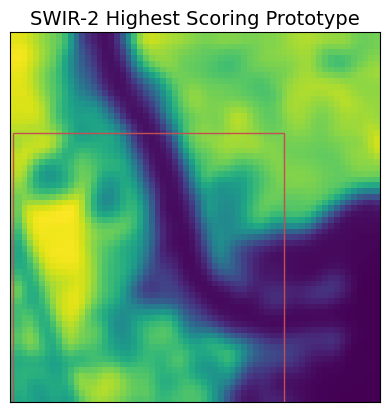

Second Winning Prototype Label: tensor(8, device='cpu')
Second Winning Prototype Number: 512
Second Winning Prototype Score: 0.576219
Second Winning Prototype Channel: 12


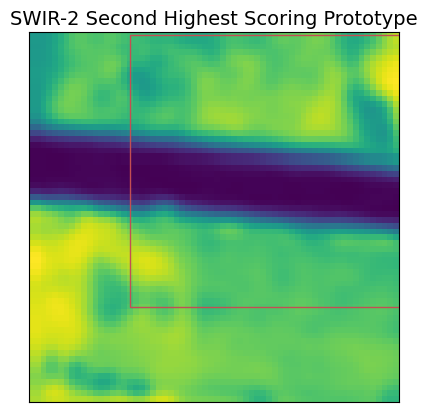

Winning Channel Prototype: 34
Winning Channel Prototype Score: 1.0987962


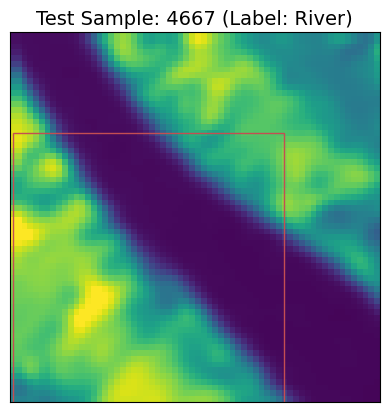

Channel: 0
Winning Channel Prototype: 2
Winning Channel Prototype Score: 0.36955446
Training Sample Prototype Label: tensor(0, device='cpu')
Channel: 1
Winning Channel Prototype: 10
Winning Channel Prototype Score: 0.13766746
Training Sample Prototype Label: tensor(2, device='cpu')
Channel: 2
Winning Channel Prototype: 16
Winning Channel Prototype Score: 0.22599472
Training Sample Prototype Label: tensor(4, device='cpu')
Channel: 3
Winning Channel Prototype: 0
Winning Channel Prototype Score: 0.11724927
Training Sample Prototype Label: tensor(0, device='cpu')
Channel: 4
Winning Channel Prototype: 25
Winning Channel Prototype Score: 0.046798777
Training Sample Prototype Label: tensor(6, device='cpu')
Channel: 5
Winning Channel Prototype: 33
Winning Channel Prototype Score: 0.56897646
Training Sample Prototype Label: tensor(8, device='cpu')
Channel: 6
Winning Channel Prototype: 32
Winning Channel Prototype Score: 0.48054755
Training Sample Prototype Label: tensor(8, device='cpu')
Channel

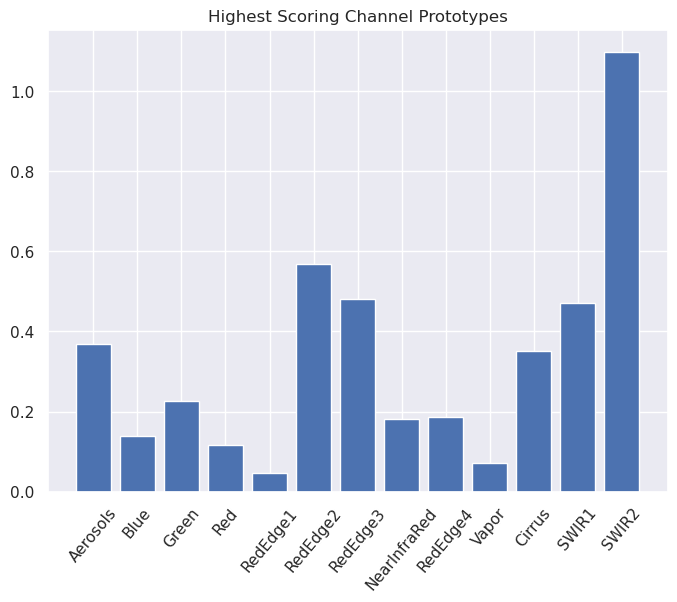

In [15]:
#4667 river
#anual crop 201, 203
#forest 618

#highway 1823 2165
#2274,2300
test_images = test_images.cpu()
sns.reset_defaults()
plt.style.use('default')
plt.rcdefaults()

for q in range(4667, 4668):
    pred_lab = pred_label[q]
    weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
    sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
    scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

    scores_sort = np.argsort(scores)
    ind = scores_sort[-1]
    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']

    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])

    print('Test Sample Number: '+str(q))
    print('Winning Prototype Label: '+str(all_labels[proto_ind]))
    print('Winning Prototype Number: '+str(ind)) # out of 240
    print('Winning Prototype Score: '+str(scores[ind]))
    print('Winning Prototype Channel: '+str(chan_num))

    #Plot highest scoring prototype
    ax, vmin, vmax = plot_prototype(ind, chan_rf, input_size, plt.gca(), all_conv_prototypes, all_prototype_sample_ind, all_images, show=False, return_axes=True)
    ax.set_title('SWIR-2 Highest Scoring Prototype', fontsize=14)
    #plt.savefig("rs_figs/rs_4667_highest.pdf", format="pdf",bbox_inches='tight')
    plt.show()

    ind2 = scores_sort[-2]
    chan_num2 = ind2 // exp_var_dict['num_prototypes']
    all_num = ind2 % exp_var_dict['num_prototypes']
    proto_ind2 = int(all_prototype_sample_ind[chan_num][all_num])
    print('Second Winning Prototype Label: '+str(all_labels[proto_ind2]))
    print('Second Winning Prototype Number: '+str(ind2)) # out of 240
    print('Second Winning Prototype Score: '+str(scores[ind2]))
    print('Second Winning Prototype Channel: '+str(chan_num2))

    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']
    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])

    #Plot second highest scoring prototype
    ax, _, _ = plot_prototype(ind2, chan_rf, input_size, plt.gca(), all_conv_prototypes, all_prototype_sample_ind, all_images, show=False, return_axes=True)
    ax.set_title('SWIR-2 Second Highest Scoring Prototype', fontsize=14)
    #plt.savefig("rs_figs/rs_4667_secondhighest.pdf", format="pdf",bbox_inches='tight')
    plt.show()

    score_plot = []
    sim_values = all_max_sims[q,chan_num,:] 
    scores = sim_values * weights[pred_lab,chan_num*exp_var_dict['num_prototypes']:(chan_num+1)*exp_var_dict['num_prototypes']]

    scores_sort = np.argsort(scores)
    ind = scores_sort[-1]
    print('Winning Channel Prototype: '+str(ind))
    print('Winning Channel Prototype Score: '+str(scores[ind]))
    i = all_max_inds[q][chan_num][ind][0]
    j = all_max_inds[q][chan_num][ind][1]

    input_mask, y1, y2, x1, x2 = output_to_input(i,j,chan_rf[chan_num][0], chan_rf[chan_num][1], chan_rf[chan_num][2], chan_rf[chan_num][3], input_size)
    
    xy = (x1, y1)
    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')

    #Plot test sample
    plt.imshow(test_images[q,chan_num,:,:],vmin=vmin, vmax=vmax)
    ax = plt.gca()
    ax.add_patch(rect)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Test Sample: 4667 (Label: River)', fontsize=14)
    #plt.savefig("rs_figs/rs_4667.pdf", format="pdf",bbox_inches='tight')
    plt.show()
    
    for chan in range(0,exp_var_dict['num_channels']):
        print('Channel: '+str(chan))
        sim_values = all_max_sims[q,chan,:] 
        scores = sim_values * weights[pred_lab,chan*exp_var_dict['num_prototypes']:(chan+1)*exp_var_dict['num_prototypes']]

        scores_sort = np.argsort(scores)
        ind = scores_sort[-1]
        proto_ind = int(all_prototype_sample_ind[chan][ind]) 
        print('Winning Channel Prototype: '+str(ind))
        print('Winning Channel Prototype Score: '+str(scores[ind]))
        print('Training Sample Prototype Label: '+str(all_labels[proto_ind]))
        score_plot.append(scores[ind])
        
        #Uncomment below to visualize the highest scoring prototype from each channel
        """
        plt.imshow(all_images[proto_ind,chan,:,:])
        ax = plt.gca()            
        i = int(all_conv_prototypes[chan][ind,0])
        j = int(all_conv_prototypes[chan][ind,1])
        input_mask, y1, y2, x1, x2 = output_to_input(i,j,chan_rf[chan][0], chan_rf[chan][1], chan_rf[chan][2], chan_rf[chan][3], input_size)
        xy = (x1, y1)
        rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()
        """
        
        sns.set_theme()
        plt.figure(figsize=(8, 6))
        x = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NearInfraRed', 'RedEdge4','Vapor','Cirrus','SWIR1','SWIR2']
        plt.bar(x,score_plot)
        plt.title('Highest Scoring Channel Prototypes')
        plt.xticks(rotation=50)
        #plt.savefig("rs_figs/rs_4667_scores.pdf", format="pdf",bbox_inches='tight')
        plt.show()



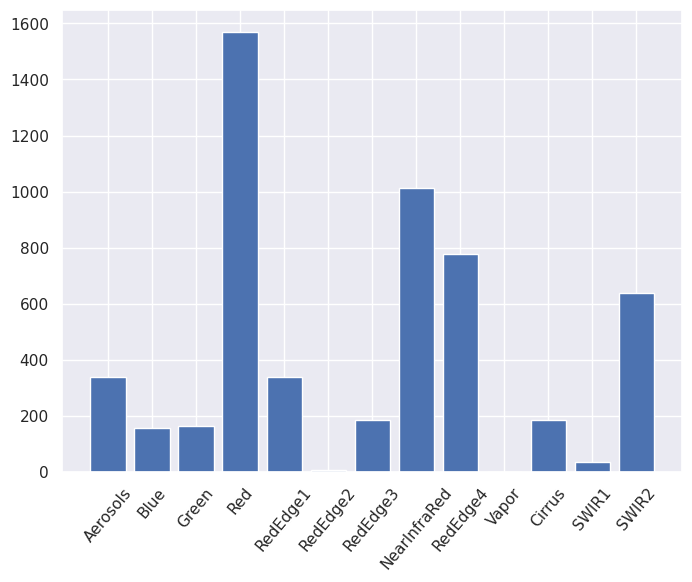

In [16]:
all_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) 
correct1_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) #correct and correct winning proto label
second_correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
third_correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
incorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
    
for q in range(len(test_images)):
    pred_lab = pred_label[q]
    weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
    sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
    scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

    scores_sort = np.argsort(scores)
    ind1 = scores_sort[-1]
    chan_num = ind1 // exp_var_dict['num_prototypes']
    all_num = ind1 % exp_var_dict['num_prototypes']

    all_overall_prototype_winning_count[chan_num][all_num] += 1
    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
    if correct[q] == 1:
        correct_overall_prototype_winning_count[chan_num][all_num] += 1
        if int(all_labels[proto_ind]) == int(true_label[q]):
            correct1_overall_prototype_winning_count[chan_num][all_num] += 1
        ind2 = scores_sort[-2]
        chan_num = ind2 // exp_var_dict['num_prototypes']
        all_num = ind2 % exp_var_dict['num_prototypes']
        proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
        if int(all_labels[proto_ind]) == int(true_label[q]):
            second_correct_overall_prototype_winning_count[chan_num][all_num] += 1
        ind3 = scores_sort[-3]
        chan_num = ind3 // exp_var_dict['num_prototypes']
        all_num = ind3 % exp_var_dict['num_prototypes']
        proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
        if int(all_labels[proto_ind]) == int(true_label[q]):
            third_correct_overall_prototype_winning_count[chan_num][all_num] += 1
    else:
        incorrect_overall_prototype_winning_count[chan_num][all_num] +=1


x = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NearInfraRed', 'RedEdge4','Vapor','Cirrus','SWIR1','SWIR2']
plt.figure(figsize=(8, 6))
plt.bar(x,np.sum(all_overall_prototype_winning_count, axis=1))
plt.xticks(rotation=50)
#plt.savefig("paper_figs/rs_all.eps", format="eps",bbox_inches='tight')
plt.show()

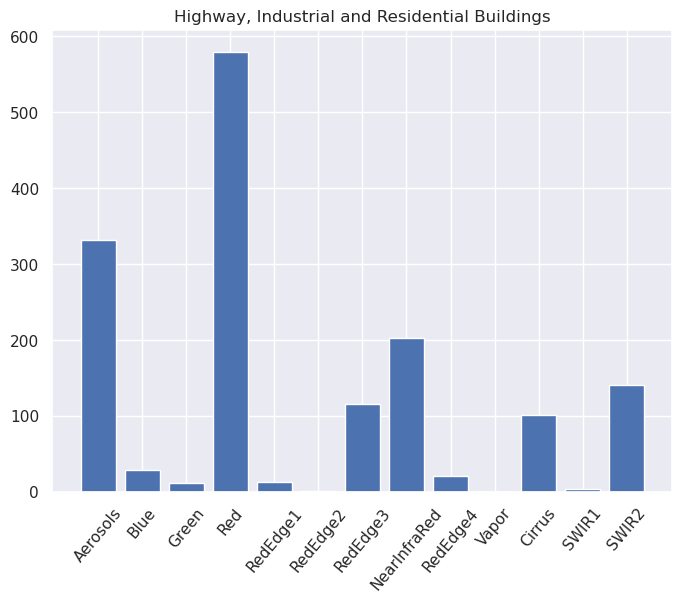

In [20]:
all_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) 
correct1_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) #correct and correct winning proto label
incorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
for q in range(len(test_images)):
    pred_lab = pred_label[q]
    if true_label[q] == 3 or true_label[q] == 4 or true_label[q] == 7: 
        weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
        sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
        scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

        scores_sort = np.argsort(scores)
        ind1 = scores_sort[-1]
        chan_num = ind1 // exp_var_dict['num_prototypes']
        all_num = ind1 % exp_var_dict['num_prototypes']

        all_overall_prototype_winning_count[chan_num][all_num] += 1
        proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
        if correct[q] == 1:
            correct_overall_prototype_winning_count[chan_num][all_num] += 1
            if int(all_labels[proto_ind]) == int(true_label[q]):
                correct1_overall_prototype_winning_count[chan_num][all_num] += 1
        else:
            incorrect_overall_prototype_winning_count[chan_num][all_num] +=1

plt.figure(figsize=(8, 6))
x = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NearInfraRed', 'RedEdge4','Vapor','Cirrus','SWIR1','SWIR2']
plt.bar(x,np.sum(all_overall_prototype_winning_count, axis=1))
plt.xticks(rotation=50)
plt.title('Highway, Industrial and Residential Buildings')
plt.show()
#plt.savefig("paper_figs/rs_building.eps", format="eps",bbox_inches='tight')

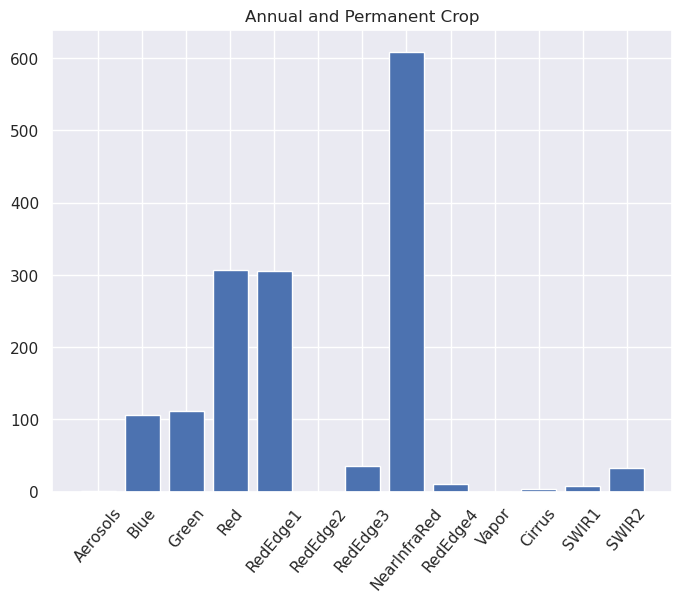

In [21]:
all_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) 
correct1_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) #correct and correct winning proto label
incorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
for q in range(len(test_images)):
    pred_lab = pred_label[q]
    if true_label[q] == 0 or true_label[q] == 5 or true_label[q] == 6: 
        weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
        sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
        scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

        scores_sort = np.argsort(scores)
        ind1 = scores_sort[-1]
        chan_num = ind1 // exp_var_dict['num_prototypes']
        all_num = ind1 % exp_var_dict['num_prototypes']

        all_overall_prototype_winning_count[chan_num][all_num] += 1
        proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
        if correct[q] == 1:
            correct_overall_prototype_winning_count[chan_num][all_num] += 1
            if int(all_labels[proto_ind]) == int(true_label[q]):
                correct1_overall_prototype_winning_count[chan_num][all_num] += 1
        else:
            incorrect_overall_prototype_winning_count[chan_num][all_num] +=1

plt.figure(figsize=(8, 6))
x = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NearInfraRed', 'RedEdge4','Vapor','Cirrus','SWIR1','SWIR2']
plt.bar(x,np.sum(all_overall_prototype_winning_count, axis=1))
plt.xticks(rotation=50)
plt.title('Annual and Permanent Crop')
plt.show()
#plt.savefig("paper_figs/rs_crop.eps", format="eps",bbox_inches='tight')

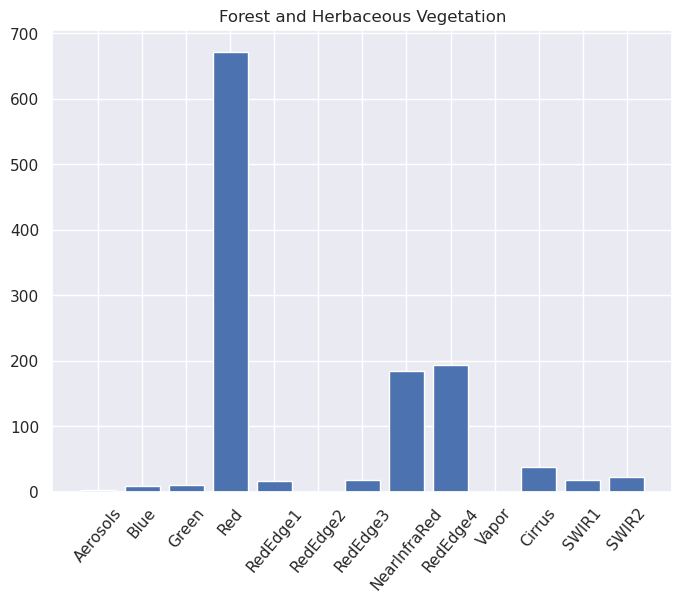

In [22]:
all_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) 
correct1_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) #correct and correct winning proto label
incorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
for q in range(len(test_images)):
    pred_lab = pred_label[q]
    if true_label[q] == 1 or true_label[q] == 2: 
        weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
        sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
        scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

        scores_sort = np.argsort(scores)
        ind1 = scores_sort[-1]
        chan_num = ind1 // exp_var_dict['num_prototypes']
        all_num = ind1 % exp_var_dict['num_prototypes']

        all_overall_prototype_winning_count[chan_num][all_num] += 1
        proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
        if correct[q] == 1:
            correct_overall_prototype_winning_count[chan_num][all_num] += 1
            if int(all_labels[proto_ind]) == int(true_label[q]):
                correct1_overall_prototype_winning_count[chan_num][all_num] += 1
        else:
            incorrect_overall_prototype_winning_count[chan_num][all_num] +=1

plt.figure(figsize=(8, 6))
x = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NearInfraRed', 'RedEdge4','Vapor','Cirrus','SWIR1','SWIR2']
plt.bar(x,np.sum(all_overall_prototype_winning_count, axis=1))
plt.xticks(rotation=50)
plt.title('Forest and Herbaceous Vegetation')
plt.show()
#plt.savefig("paper_figs/rs_forestveg.eps", format="eps",bbox_inches='tight')

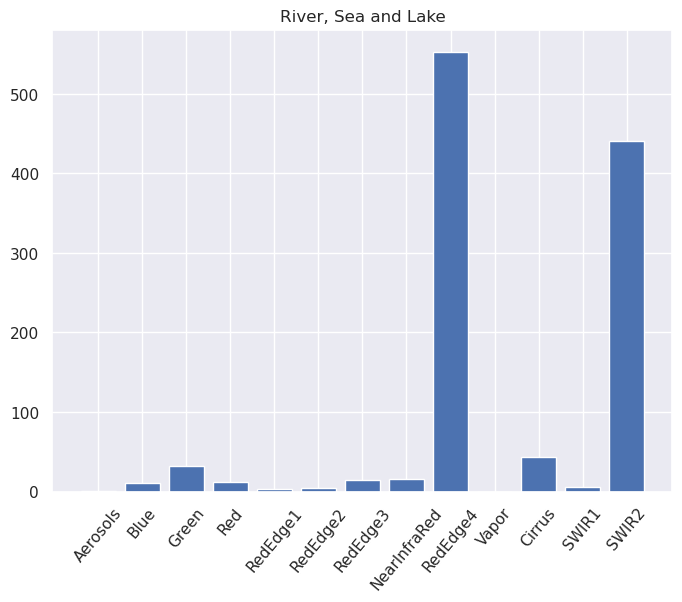

In [23]:
all_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) 
correct1_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) #correct and correct winning proto label
incorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
for q in range(len(test_images)):
    pred_lab = pred_label[q]
    if true_label[q] == 8 or true_label[q] == 9: 
        weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
        sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
        scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

        scores_sort = np.argsort(scores)
        ind1 = scores_sort[-1]
        chan_num = ind1 // exp_var_dict['num_prototypes']
        all_num = ind1 % exp_var_dict['num_prototypes']

        all_overall_prototype_winning_count[chan_num][all_num] += 1
        proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
        if correct[q] == 1:
            correct_overall_prototype_winning_count[chan_num][all_num] += 1
            if int(all_labels[proto_ind]) == int(true_label[q]):
                correct1_overall_prototype_winning_count[chan_num][all_num] += 1
        else:
            incorrect_overall_prototype_winning_count[chan_num][all_num] +=1

plt.figure(figsize=(8, 6))
x = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NearInfraRed', 'RedEdge4','Vapor','Cirrus','SWIR1','SWIR2']
plt.bar(x,np.sum(all_overall_prototype_winning_count, axis=1))
plt.xticks(rotation=50)
plt.title('River, Sea and Lake')
plt.show()
#plt.savefig("paper_figs/rs_riversea.eps", format="eps",bbox_inches='tight')

120
Modes: [120, 280, 281]
Values: [221, 127, 118]
Training Sample Prototype Number: 1253
Training Sample Channel: 3
Training Sample Prototype Label: tensor(0, device='cpu')


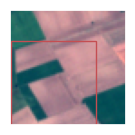

Training Sample Prototype Number: 1468
Training Sample Channel: 7
Training Sample Prototype Label: tensor(0, device='cpu')


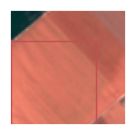

Training Sample Prototype Number: 80
Training Sample Channel: 7
Training Sample Prototype Label: tensor(0, device='cpu')


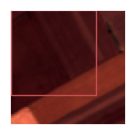

125
Modes: [125, 284, 286]
Values: [555, 107, 71]
Training Sample Prototype Number: 3237
Training Sample Channel: 3
Training Sample Prototype Label: tensor(1, device='cpu')


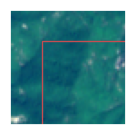

Training Sample Prototype Number: 3086
Training Sample Channel: 7
Training Sample Prototype Label: tensor(1, device='cpu')


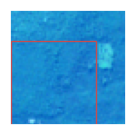

Training Sample Prototype Number: 2767
Training Sample Channel: 7
Training Sample Prototype Label: tensor(1, device='cpu')


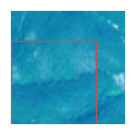

289
Modes: [289, 130, 49]
Values: [43, 22, 12]
Training Sample Prototype Number: 5175
Training Sample Channel: 7
Training Sample Prototype Label: tensor(2, device='cpu')


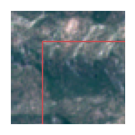

Training Sample Prototype Number: 4653
Training Sample Channel: 3
Training Sample Prototype Label: tensor(2, device='cpu')


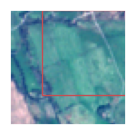

Training Sample Prototype Number: 5354
Training Sample Channel: 1
Training Sample Prototype Label: tensor(2, device='cpu')


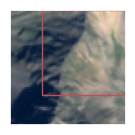

174
Modes: [174, 413, 494]
Values: [200, 46, 32]
Training Sample Prototype Number: 6629
Training Sample Channel: 4
Training Sample Prototype Label: tensor(3, device='cpu')


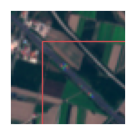

Training Sample Prototype Number: 6251
Training Sample Channel: 10
Training Sample Prototype Label: tensor(3, device='cpu')


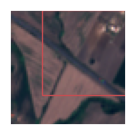

Training Sample Prototype Number: 6486
Training Sample Channel: 12
Training Sample Prototype Label: tensor(3, device='cpu')


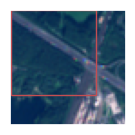

17
Modes: [17, 419, 139]
Values: [327, 84, 28]
Training Sample Prototype Number: 7572
Training Sample Channel: 0
Training Sample Prototype Label: tensor(4, device='cpu')


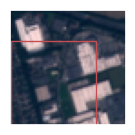

Training Sample Prototype Number: 7891
Training Sample Channel: 10
Training Sample Prototype Label: tensor(4, device='cpu')


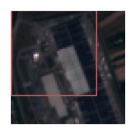

Training Sample Prototype Number: 7292
Training Sample Channel: 3
Training Sample Prototype Label: tensor(4, device='cpu')


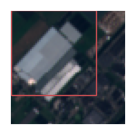

342
Modes: [342, 300, 62]
Values: [204, 124, 34]
Training Sample Prototype Number: 8825
Training Sample Channel: 8
Training Sample Prototype Label: tensor(5, device='cpu')


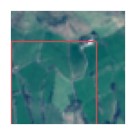

Training Sample Prototype Number: 8706
Training Sample Channel: 7
Training Sample Prototype Label: tensor(5, device='cpu')


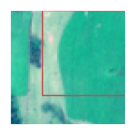

Training Sample Prototype Number: 9353
Training Sample Channel: 1
Training Sample Prototype Label: tensor(5, device='cpu')


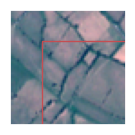

305
Modes: [305, 145, 307]
Values: [274, 77, 11]
Training Sample Prototype Number: 11022
Training Sample Channel: 7
Training Sample Prototype Label: tensor(6, device='cpu')


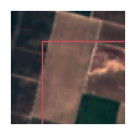

Training Sample Prototype Number: 10193
Training Sample Channel: 3
Training Sample Prototype Label: tensor(6, device='cpu')


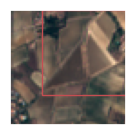

Training Sample Prototype Number: 10231
Training Sample Channel: 7
Training Sample Prototype Label: tensor(6, device='cpu')


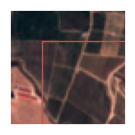

148
Modes: [148, 188, 151]
Values: [274, 127, 123]
Training Sample Prototype Number: 11598
Training Sample Channel: 3
Training Sample Prototype Label: tensor(7, device='cpu')


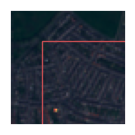

Training Sample Prototype Number: 12460
Training Sample Channel: 4
Training Sample Prototype Label: tensor(7, device='cpu')


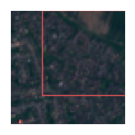

Training Sample Prototype Number: 11681
Training Sample Channel: 3
Training Sample Prototype Label: tensor(7, device='cpu')


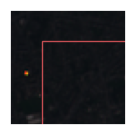

514
Modes: [514, 313, 315]
Values: [390, 71, 26]
Training Sample Prototype Number: 13154
Training Sample Channel: 12
Training Sample Prototype Label: tensor(8, device='cpu')


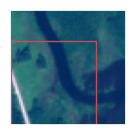

Training Sample Prototype Number: 14243
Training Sample Channel: 7
Training Sample Prototype Label: tensor(8, device='cpu')


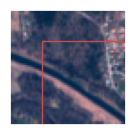

Training Sample Prototype Number: 13138
Training Sample Channel: 7
Training Sample Prototype Label: tensor(8, device='cpu')


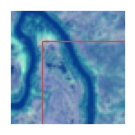

356
Modes: [356, 76, 156]
Values: [546, 46, 43]
Training Sample Prototype Number: 15419
Training Sample Channel: 8
Training Sample Prototype Label: tensor(9, device='cpu')


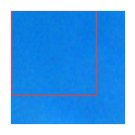

Training Sample Prototype Number: 14552
Training Sample Channel: 1
Training Sample Prototype Label: tensor(9, device='cpu')


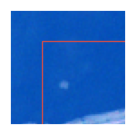

Training Sample Prototype Number: 15441
Training Sample Channel: 3
Training Sample Prototype Label: tensor(9, device='cpu')


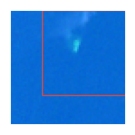

In [25]:

all_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) 
correct1_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) #correct and correct winning proto label
incorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
for label in range(0,10):
    proto_ind_count = []
    for q in range(len(test_images)):
        #if pred_label[q] == 0:
        pred_lab = pred_label[q]
        weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
        sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
        scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

        scores_sort = np.argsort(scores)
        ind1 = scores_sort[-1]
        chan_num = ind1 // exp_var_dict['num_prototypes']
        all_num = ind1 % exp_var_dict['num_prototypes']

        proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
        if all_labels[proto_ind] == label:
            proto_ind_count.append(ind1)
        if correct[q] == 1:
            correct_overall_prototype_winning_count[chan_num][all_num] += 1
            if int(all_labels[proto_ind]) == int(true_label[q]):
                correct1_overall_prototype_winning_count[chan_num][all_num] += 1
        else:
            incorrect_overall_prototype_winning_count[chan_num][all_num] +=1

    ind = mode(proto_ind_count)
    print(ind)

    from collections import Counter

    freq = Counter(proto_ind_count)

    top3 = freq.most_common(3)

    modes_only = [value for value, count in top3]
    count_only = [count for value, count in top3]
    print("Modes:", modes_only)
    print("Values:", count_only)

    #fig, axs = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    chan_num = modes_only[0] // exp_var_dict['num_prototypes']
    all_num = modes_only[0] % exp_var_dict['num_prototypes']
    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
    print('Training Sample Prototype Number: '+str(proto_ind))
    print('Training Sample Channel: '+str(chan_num))
    print('Training Sample Prototype Label: '+str(all_labels[proto_ind]))

    fig, axs = plt.subplots(figsize=(1.5, 1.5))
    ax, _, _ = plot_prototype(modes_only[0], chan_rf, input_size, axs, all_conv_prototypes, all_prototype_sample_ind, all_images, rgb=True, show=False, return_axes=True)
    #plt.savefig("rs_figs/rs"+str(all_labels[proto_ind].item())+"_1chan"+str(chan_num)+".pdf", format="pdf",bbox_inches='tight')

    plt.show()

    chan_num = modes_only[1] // exp_var_dict['num_prototypes']
    all_num = modes_only[1] % exp_var_dict['num_prototypes']
    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
    print('Training Sample Prototype Number: '+str(proto_ind))
    print('Training Sample Channel: '+str(chan_num))
    print('Training Sample Prototype Label: '+str(all_labels[proto_ind]))

    fig, axs = plt.subplots(figsize=(1.5, 1.5))

    ax, _, _ = plot_prototype(modes_only[1], chan_rf, input_size, axs, all_conv_prototypes, all_prototype_sample_ind, all_images, rgb=True, show=False, return_axes=True)
    #plt.savefig("rs_figs/rs"+str(all_labels[proto_ind].item())+"_2chan"+str(chan_num)+".pdf", format="pdf",bbox_inches='tight')

    plt.show()


    chan_num = modes_only[2] // exp_var_dict['num_prototypes']
    all_num = modes_only[2] % exp_var_dict['num_prototypes']
    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
    print('Training Sample Prototype Number: '+str(proto_ind))
    print('Training Sample Channel: '+str(chan_num))
    print('Training Sample Prototype Label: '+str(all_labels[proto_ind]))

    fig, axs = plt.subplots(figsize=(1.5, 1.5))

    ax, _, _ = plot_prototype(modes_only[2], chan_rf, input_size, axs, all_conv_prototypes, all_prototype_sample_ind, all_images, rgb=True, show=False, return_axes=True)
    #plt.savefig("rs_figs/rs"+str(all_labels[proto_ind].item())+"_3chan"+str(chan_num)+".pdf", format="pdf",bbox_inches='tight')

    plt.show()



